<a href="https://colab.research.google.com/github/Shubham-Gandhi-018/CS_715-Final-Project/blob/main/Air_Quality_(Strategy_A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Code Overview:**
- **In this notebook, UCI Air Quality dataset is used to predict next-hour CO concentration using three recurrent models:   mGRN (Memory-Gated Recurrent Network), GRU, and LSTM.**

- **I kept the same training hyperparameters for all three models to ensure a fair architectural comparison**

# **Section 1 — Imports & Configuration**

In [ ]:
# Imports
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# **Section 2 — Load & Clean AirQuality Dataset**

In [ ]:
# Path to your AirQualityUCI.csv file
csv_path = "AirQualityUCI.xlsx"  # adjust if needed

df = pd.read_excel(csv_path)
# Drop last 2 empty columns if present
# df = df.iloc[:, :-2] # This line was causing the error by dropping 'RH' and 'AH'

# Replace missing value code
df = df.replace(-200, np.nan)

# Forward-fill then back-fill
df = df.ffill().bfill()

# Select 13 features
feature_cols = [
    'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH'
]

df = df[feature_cols].dropna().reset_index(drop=True)
df.head()


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80.0,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51.0,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


📌 Explanation for the above code:

- cleaned missing values, and select 13 key features (10 pollution/sensor variables + 3 weather variables).

- Missing values coded as -200 are replaced using forward–backward filling.

# **Section 3 — Define Target, Scale, and Make Sequences**

In [ ]:
data = df.values.astype(np.float32)

# Target is CO(GT) — column index 0
target_idx = 0

# Scale all features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

def make_sequences(data_array, input_len=24, pred_horizon=1, target_idx=0):
    X, y = [], []
    for i in range(len(data_array) - input_len - pred_horizon + 1):
        X.append(data_array[i : i + input_len])  # window of 24 hours
        y.append(data_array[i + input_len + pred_horizon - 1, target_idx])  # next-hour CO
    return np.array(X), np.array(y)

input_len = 24
X, y = make_sequences(data_scaled, input_len=input_len, pred_horizon=1, target_idx=target_idx)

# Train/val/test split (no shuffle to preserve time order)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, shuffle=False
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

X_train.shape, X_val.shape, X_test.shape


((6999, 24, 13), (1167, 24, 13), (1167, 24, 13))

📌 Explanation for the above code:

- The goal is to predict next-hour CO(GT) using the past 24 hours of all 13 features.

- We standardize the features and convert the time series into sliding windows of length 24.

# **Section 4 — PyTorch Dataset & DataLoaders**

In [ ]:
class AirQualitySeq(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = AirQualitySeq(X_train, y_train)
val_ds   = AirQualitySeq(X_val,   y_val)
test_ds  = AirQualitySeq(X_test,  y_test)

batch_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


📌 Explanation for the above code:

- Wraped the NumPy arrays into a PyTorch Dataset and use DataLoader to handle batching.

- Only the training loader is shuffled; validation and test loaders preserve order.

# **Section 5 — mGRN Model with 3 Feature Groups**

In [ ]:
# Feature indices:
# 0: CO(GT)
# 1: PT08.S1(CO)
# 2: NMHC(GT)
# 3: C6H6(GT)
# 4: PT08.S2(NMHC)
# 5: NOx(GT)
# 6: PT08.S3(NOx)
# 7: NO2(GT)
# 8: PT08.S4(NO2)
# 9: PT08.S5(O3)
# 10: T
# 11: RH
# 12: AH

groups_3 = [
    (0, 5),   # CO + first sensor block
    (5, 9),   # NOx-related block
    (9, 13)   # O3 sensor + weather
]

class MarginalGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W_r = nn.Linear(input_dim, hidden_dim)
        self.U_r = nn.Linear(hidden_dim, hidden_dim)

        self.W_z = nn.Linear(input_dim, hidden_dim)
        self.U_z = nn.Linear(hidden_dim, hidden_dim)

        self.W_h = nn.Linear(input_dim, hidden_dim)
        self.U_h = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x_t, h_prev):
        r_t = torch.sigmoid(self.W_r(x_t) + self.U_r(h_prev))
        z_t = torch.sigmoid(self.W_z(x_t) + self.U_z(h_prev))
        h_tilde = torch.tanh(self.W_h(x_t) + r_t * self.U_h(h_prev))
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t, h_tilde

class mGRN(nn.Module):
    def __init__(self, input_dim, groups, m_hidden=32, j_hidden=64, output_dim=1):
        super().__init__()
        self.groups = groups
        self.num_groups = len(groups)
        self.m_hidden = m_hidden
        self.j_hidden = j_hidden

        # One marginal GRU per group
        self.marginals = nn.ModuleList([
            MarginalGRU(e - s, m_hidden)
            for (s, e) in groups
        ])

        # Joint update gate
        self.W_z = nn.Linear(input_dim, j_hidden)
        self.U_z = nn.Linear(j_hidden, j_hidden)

        # Combine marginal candidates
        self.U_c = nn.ModuleList([
            nn.Linear(m_hidden, j_hidden, bias=False)
            for _ in range(self.num_groups)
        ])
        self.b_c = nn.Parameter(torch.zeros(j_hidden))

        # Final regression head
        self.fc = nn.Linear(j_hidden, output_dim)

    def forward(self, x):
        B, T, D = x.shape
        h_m = [x.new_zeros((B, self.m_hidden)) for _ in range(self.num_groups)]
        h_joint = x.new_zeros((B, self.j_hidden))

        for t in range(T):
            x_t = x[:, t, :]
            cand = []

            # 1) Marginal updates
            for gi, (s, e) in enumerate(self.groups):
                x_g = x_t[:, s:e]
                h_m[gi], h_tilde = self.marginals[gi](x_g, h_m[gi])
                cand.append(h_tilde)

            # 2) Build joint candidate
            joint_in = sum(self.U_c[i](cand[i]) for i in range(self.num_groups))
            h_tilde_joint = torch.tanh(joint_in + self.b_c)

            # 3) Joint update gate
            z_t = torch.sigmoid(self.W_z(x_t) + self.U_z(h_joint))
            h_joint = (1 - z_t) * h_joint + z_t * h_tilde_joint

        out = self.fc(h_joint)  # (B, 1)
        return out.squeeze(1)



📌 Explanation for the above code:

For mGRN, we split the 13 features into three logical groups:

  - Group 1 (0–4): early gas and sensor readings (5 variables)

  - Group 2 (5–8): NOx-related indicators (4 variables)

  - Group 3 (9–12): ozone sensor + weather (4 variables)

Each group has its own marginal GRU to learn within-group patterns. The joint memory then combines these candidate memories to capture cross-group dependencies.

# **Section 6 — GRU & LSTM Baseline Models**

In [ ]:
class GRUReg(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64, output_dim=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)               # (B, T, H)
        last = out[:, -1, :]               # last time step
        return self.fc(last).squeeze(1)    # (B,)

class LSTMReg(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last).squeeze(1)


📌 Explanation for the above code:

GRU and LSTM are used as baselines.
Each baseline consumes the full 13-dimensional sequence, and uses the final hidden state to predict next-hour CO.

# **Section 7 — Shared Training Loop (Regression)**

In [ ]:
LR = 1e-3
EPOCHS = 30  # same for all three models

criterion = nn.MSELoss()

def run_epoch(model, loader, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    with torch.set_grad_enabled(optimizer is not None):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * xb.size(0)

    return total_loss / len(loader.dataset)


📌 Explanation for the above code:

All three models use the same optimizer (Adam), learning rate, batch size, and number of epochs to keep the comparison fair.
We train using Mean Squared Error (MSE) loss.

# **Section 8 — Initialize & Train All Three Models**



In [ ]:
input_dim = X_train.shape[2]

model_mgrn = mGRN(input_dim=input_dim, groups=groups_3, m_hidden=32, j_hidden=64, output_dim=1).to(device)
model_gru  = GRUReg(input_dim=input_dim, hidden_dim=64, output_dim=1).to(device)
model_lstm = LSTMReg(input_dim=input_dim, hidden_dim=64, output_dim=1).to(device)

opt_mgrn = torch.optim.Adam(model_mgrn.parameters(), lr=LR)
opt_gru  = torch.optim.Adam(model_gru.parameters(),  lr=LR)
opt_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LR)

mgrn_train_losses, mgrn_val_losses = [], []
gru_train_losses,  gru_val_losses  = [], []
lstm_train_losses, lstm_val_losses = [], []

# Train mGRN
for epoch in range(EPOCHS):
    tr = run_epoch(model_mgrn, train_loader, opt_mgrn)
    va = run_epoch(model_mgrn, val_loader,   None)
    mgrn_train_losses.append(tr)
    mgrn_val_losses.append(va)
    print(f"[mGRN] Epoch {epoch+1:02d} | Train={tr:.4f} | Val={va:.4f}")

# Train GRU
for epoch in range(EPOCHS):
    tr = run_epoch(model_gru, train_loader, opt_gru)
    va = run_epoch(model_gru, val_loader,   None)
    gru_train_losses.append(tr)
    gru_val_losses.append(va)
    print(f"[GRU]  Epoch {epoch+1:02d} | Train={tr:.4f} | Val={va:.4f}")

# Train LSTM
for epoch in range(EPOCHS):
    tr = run_epoch(model_lstm, train_loader, opt_lstm)
    va = run_epoch(model_lstm, val_loader,   None)
    lstm_train_losses.append(tr)
    lstm_val_losses.append(va)
    print(f"[LSTM] Epoch {epoch+1:02d} | Train={tr:.4f} | Val={va:.4f}")


[mGRN] Epoch 01 | Train=0.3473 | Val=0.2516
[mGRN] Epoch 02 | Train=0.2077 | Val=0.2173
[mGRN] Epoch 03 | Train=0.1973 | Val=0.2061
[mGRN] Epoch 04 | Train=0.1885 | Val=0.2131
[mGRN] Epoch 05 | Train=0.1814 | Val=0.2161
[mGRN] Epoch 06 | Train=0.1750 | Val=0.2119
[mGRN] Epoch 07 | Train=0.1702 | Val=0.1908
[mGRN] Epoch 08 | Train=0.1664 | Val=0.1959
[mGRN] Epoch 09 | Train=0.1644 | Val=0.1926
[mGRN] Epoch 10 | Train=0.1600 | Val=0.2008
[mGRN] Epoch 11 | Train=0.1598 | Val=0.1939
[mGRN] Epoch 12 | Train=0.1549 | Val=0.1924
[mGRN] Epoch 13 | Train=0.1517 | Val=0.2019
[mGRN] Epoch 14 | Train=0.1491 | Val=0.2227
[mGRN] Epoch 15 | Train=0.1462 | Val=0.1855
[mGRN] Epoch 16 | Train=0.1452 | Val=0.2260
[mGRN] Epoch 17 | Train=0.1415 | Val=0.1981
[mGRN] Epoch 18 | Train=0.1408 | Val=0.1912
[mGRN] Epoch 19 | Train=0.1393 | Val=0.1946
[mGRN] Epoch 20 | Train=0.1355 | Val=0.2010
[mGRN] Epoch 21 | Train=0.1341 | Val=0.1992
[mGRN] Epoch 22 | Train=0.1308 | Val=0.1913
[mGRN] Epoch 23 | Train=0.1285 |

# **Section 9 — Evaluate on Test Set (MSE, MAE, RMSE, MAPE, R²)**

In [ ]:
def get_test_predictions(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(trues)

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # Add small epsilon to avoid division by zero
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, mape, r2

results = {}

for name, model in [("mGRN", model_mgrn),
                    ("GRU",  model_gru),
                    ("LSTM", model_lstm)]:
    y_pred, y_true = get_test_predictions(model, test_loader)
    mse, mae, rmse, mape, r2 = regression_metrics(y_true, y_pred)
    results[name] = {
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
        "r2": r2
    }
    print(f"\n=== {name} Test Metrics ===")
    print(f"MSE  = {mse:.4f}")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAPE = {mape:.2f}%")
    print(f"R²   = {r2:.4f}")



=== mGRN Test Metrics ===
MSE  = 0.1440
MAE  = 0.2729
RMSE = 0.3794
MAPE = 153.52%
R²   = 0.8102

=== GRU Test Metrics ===
MSE  = 0.1798
MAE  = 0.2941
RMSE = 0.4241
MAPE = 172.85%
R²   = 0.7628

=== LSTM Test Metrics ===
MSE  = 0.1559
MAE  = 0.2769
RMSE = 0.3949
MAPE = 153.55%
R²   = 0.7944


📌 Explanation for the above code:

After training, measured each model on the test set using common regression metrics:
MSE, MAE, RMSE, MAPE, and R².

# **Section 10 — Visualizations for Comparison**

**10.1 Training vs Validation Loss Curves**

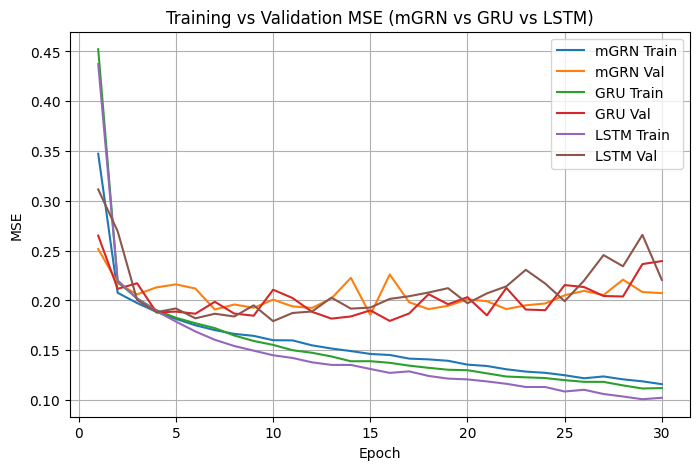

In [ ]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, mgrn_train_losses, label="mGRN Train")
plt.plot(epochs, mgrn_val_losses,   label="mGRN Val")
plt.plot(epochs, gru_train_losses,  label="GRU Train")
plt.plot(epochs, gru_val_losses,    label="GRU Val")
plt.plot(epochs, lstm_train_losses, label="LSTM Train")
plt.plot(epochs, lstm_val_losses,   label="LSTM Val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training vs Validation MSE (mGRN vs GRU vs LSTM)")
plt.legend()
plt.grid(True)
plt.show()


**10.2  Bar Chart of Test MSE / MAE / RMSE**

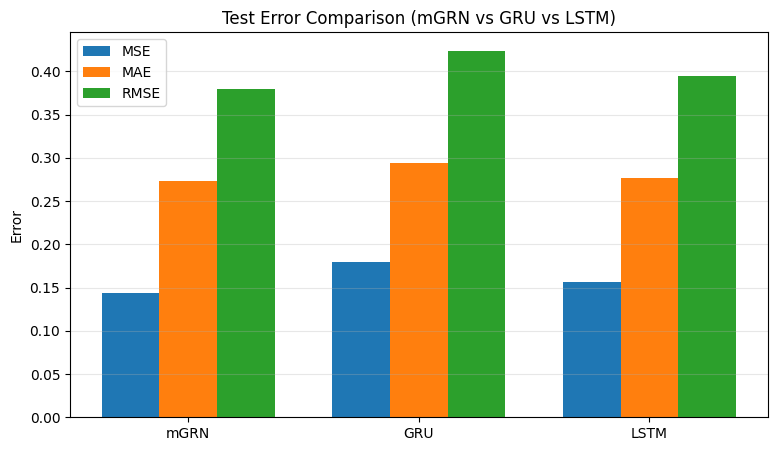

In [ ]:
models = ["mGRN", "GRU", "LSTM"]

mse_vals  = [results[m]["mse"]  for m in models]
mae_vals  = [results[m]["mae"]  for m in models]
rmse_vals = [results[m]["rmse"] for m in models]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(9,5))
plt.bar(x - width, mse_vals,  width, label="MSE")
plt.bar(x,         mae_vals,  width, label="MAE")
plt.bar(x + width, rmse_vals, width, label="RMSE")
plt.xticks(x, models)
plt.ylabel("Error")
plt.title("Test Error Comparison (mGRN vs GRU vs LSTM)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


**10.3   Radar Chart (MSE, MAE, RMSE, MAPE, R²)**

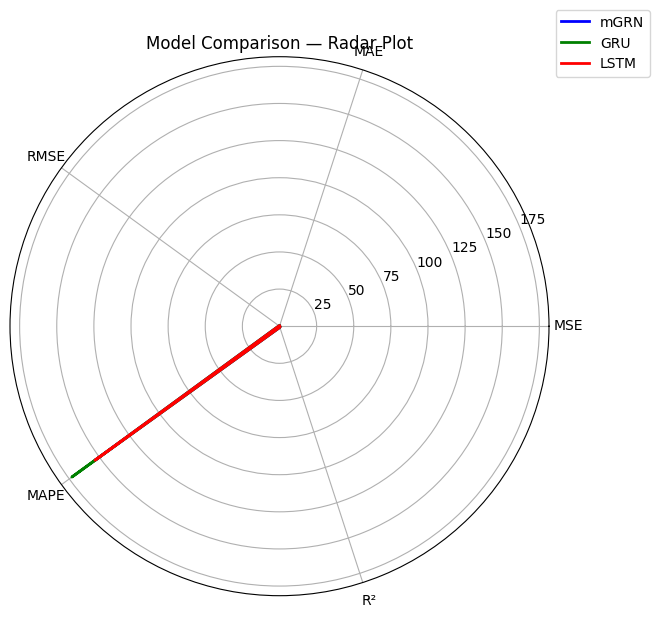

In [ ]:
labels = ["MSE", "MAE", "RMSE", "MAPE", "R²"]
num_vars = len(labels)

def radar_values(model_name):
    r = results[model_name]
    return [r["mse"], r["mae"], r["rmse"], r["mape"], r["r2"]]

# Optionally normalize some metrics if ranges are very different.
# Here we plot raw values for simplicity.

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for name, color in [("mGRN", "blue"), ("GRU", "green"), ("LSTM", "red")]:
    vals = radar_values(name)
    vals += vals[:1]
    ax.plot(angles, vals, label=name, linewidth=2, color=color)
    ax.fill(angles, vals, alpha=0.25, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Model Comparison — Radar Plot")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


**10.4 True vs Predicted CO for a Sample Window**

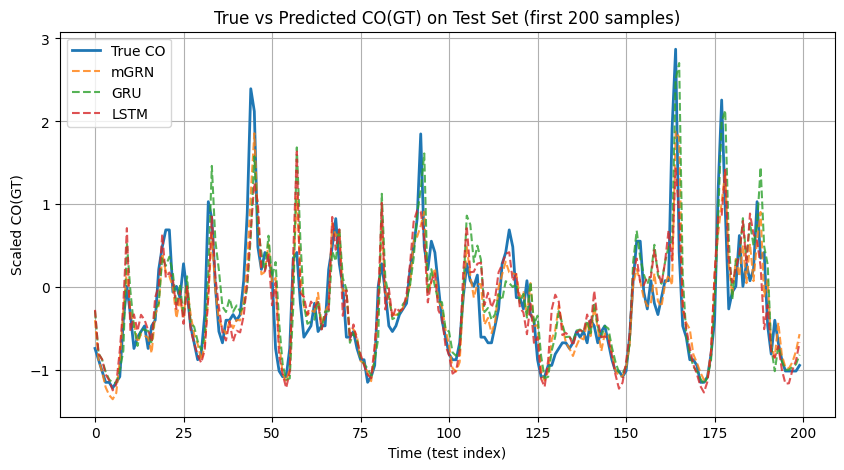

In [ ]:
# Pick a slice from the test set (e.g., first 200 points)
y_pred_mgrn, y_true_mgrn = get_test_predictions(model_mgrn, test_loader)
y_pred_gru,  _           = get_test_predictions(model_gru,  test_loader)
y_pred_lstm, _           = get_test_predictions(model_lstm, test_loader)

n_plot = 200
t_axis = np.arange(n_plot)

plt.figure(figsize=(10,5))
plt.plot(t_axis, y_true_mgrn[:n_plot],       label="True CO", linewidth=2)
plt.plot(t_axis, y_pred_mgrn[:n_plot], '--', label="mGRN", alpha=0.8)
plt.plot(t_axis, y_pred_gru[:n_plot],  '--', label="GRU", alpha=0.8)
plt.plot(t_axis, y_pred_lstm[:n_plot], '--', label="LSTM", alpha=0.8)
plt.xlabel("Time (test index)")
plt.ylabel("Scaled CO(GT)")
plt.title("True vs Predicted CO(GT) on Test Set (first 200 samples)")
plt.legend()
plt.grid(True)
plt.show()
